In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh
import random

<p style='font-size:18px'><b> Level 3 Model EDA </b></p>

In [2]:
# Load the dataset for level 3
raw_data = pd.read_csv('dataset/creditcard_train_l3.csv')

In [5]:
print("1. Number of rows (datapoints): ", raw_data.shape[0])
print("2. Number of cols (features+label): ", raw_data.shape[1])
print("\n3. Column names: ", raw_data.columns)
labels, counts = np.unique(raw_data.Class, return_counts = True)
print("\n4. Unique label values: ", labels)
print("5. Label counts: ", counts)
print("6. % of fraud transactions: {}%".format(round(100*counts[1]/(counts[0]+counts[1]),3)))
total_amount = np.sum(raw_data.Amount)
fraud_amount = np.sum(raw_data.Amount.loc[(raw_data.Class == 1)])
print("7. % of fraud transaction amount: {}%".format(round(100*fraud_amount/total_amount,3)))
print("\n8a. Total transaction amount: {}lacs".format(round(total_amount/100000, 1)))
print("8b. Fraud transactions amount: {}lacs".format(round(fraud_amount/100000, 1)))
print("\n9a. Average value of non-fraud transaction: ", round((total_amount-fraud_amount)/(raw_data.shape[0] - counts[1])))
print("9b. Average value of fraud transaction: ", round((fraud_amount)/(counts[1])))
print("\n8. Sample datapoints: ")

raw_data.iloc[np.random.randint(0,raw_data.shape[0],5)]

1. Number of rows (datapoints):  2348
2. Number of cols (features+label):  32

3. Column names:  Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour_num'],
      dtype='object')

4. Unique label values:  [0 1]
5. Label counts:  [1975  373]
6. % of fraud transactions: 15.886%
7. % of fraud transaction amount: 24.231%

8a. Total transaction amount: 1.6lacs
8b. Fraud transactions amount: 0.4lacs

9a. Average value of non-fraud transaction:  63
9b. Average value of fraud transaction:  107

8. Sample datapoints: 


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour_num
462,66792.0,-0.305315,-1.979780,-0.951412,1.783781,-0.554706,0.186699,0.904162,-0.012692,-0.225816,...,-0.691912,-0.695414,-0.414776,0.134212,-0.492852,-0.098489,0.167102,758.97,0,18
1902,67649.0,-0.736974,1.929926,-0.751711,0.839871,0.735101,0.686801,-0.843962,-2.118123,-0.951630,...,0.488787,-0.019255,-1.453043,-0.083391,-0.228147,-0.044069,0.032315,1.00,0,18
1143,143434.0,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,...,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00,1,39
680,86439.0,2.033087,-0.774613,-0.818585,-0.498218,-1.207113,-1.137887,-1.001913,-0.028368,-0.128427,...,0.939446,0.159977,0.432009,-0.283487,-0.141211,0.019239,-0.015276,29.95,0,24
488,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,1


1. Feature # randomly selected:  [ 1 18 19 27]
2. Legend: 
Fraud datapoints - Red
Not fraud datapoints - Blue 


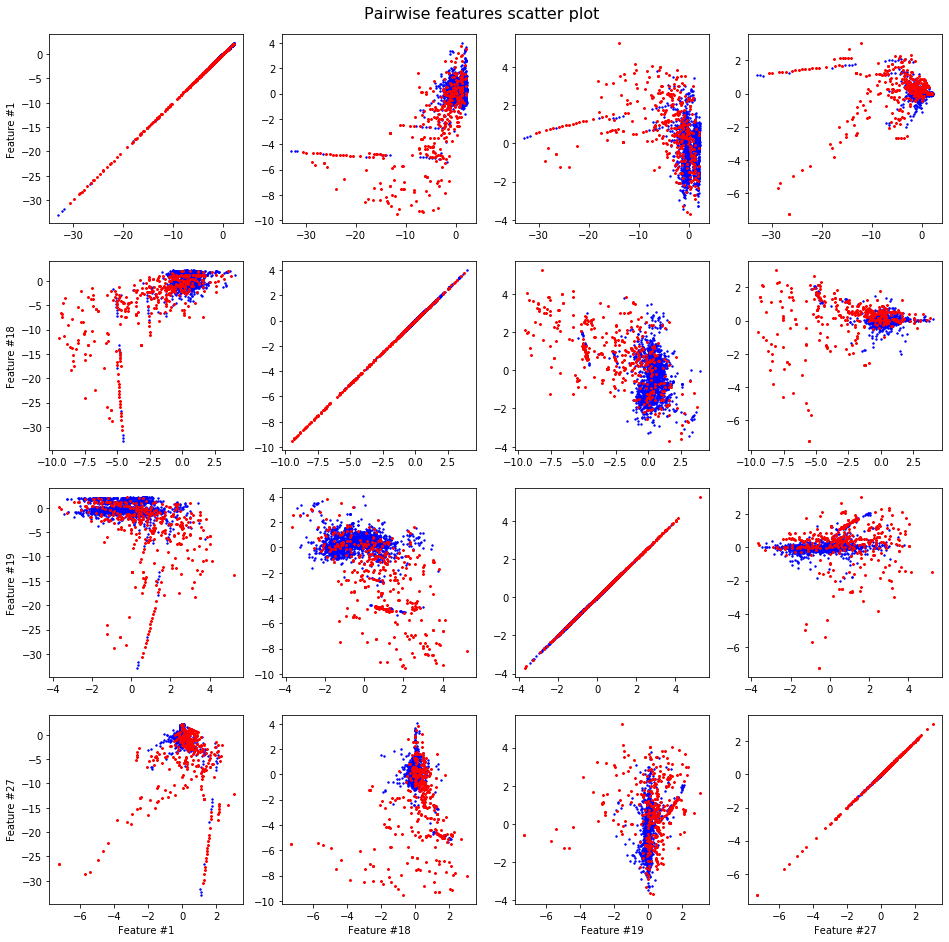

In [8]:
# Select 10 features at random and plot pair-wise scatter plot

def pairwise_plot(row, col, axs):
    
    global feature_data, feature_ind, num_features
    
    f1 = feature_ind[row]
    f2 = feature_ind[col]
    
    x = feature_data.iloc[:, f1].to_numpy()
    y = feature_data.iloc[:, f2].to_numpy()
    
    x_pos = x[(feature_data.Class == 1)]
    y_pos = y[(feature_data.Class == 1)]
    x_neg = x[(feature_data.Class == 0)]
    y_neg = y[(feature_data.Class == 0)]
    
    axs.scatter(x_neg, y_neg, label = 'Not Fraud', s = 2, c = 'b')
    axs.scatter(x_pos, y_pos, label = 'Fraud', s = 4, c = 'r', marker = 'x')

    if row == num_features-1:
        x_lab = 'Feature #' + str(f2+1)
        axs.set(xlabel = x_lab)
    if col == 0:
        y_lab = 'Feature #' + str(f1+1)
        axs.set(ylabel = y_lab)
        

# Select features at random (num_features = 4) to visualise pairwise-plots
num_features = 4
# feature_ind = np.sort(np.array(random.sample(range(28), num_features)))

# Select features in particular (num_features = 4) to visualise pairwise-plots
feature_ind = np.array([0, 17, 18, 26])

fig_size = min(16, 4*num_features)

# Setting up the pairwise plot
fig = plt.figure(figsize = (fig_size,fig_size))
fig.subplots_adjust(wspace = 0.2)
fig.suptitle('Pairwise features scatter plot', fontsize = 16, y = 0.9 + 0.001*num_features)
axs = fig.subplots(num_features,num_features)

for i in range(num_features**2):
    row = i//num_features
    col = i%num_features
    pairwise_plot(row, col, axs[row, col])

print("1. Feature # randomly selected: ", feature_ind+1)
print("2. Legend: \nFraud datapoints - Red\nNot fraud datapoints - Blue ")


<p style='font-size:16px'><b> Inferences </b></p>
<p>

- As compared to the plots in L1a_EDA & L2a_EDA, we have removed bulk of the blue points (not-fraud) from the dataset.
- The level 3 would be used to draw the final decision boundary between the two classes.     
    
</p>



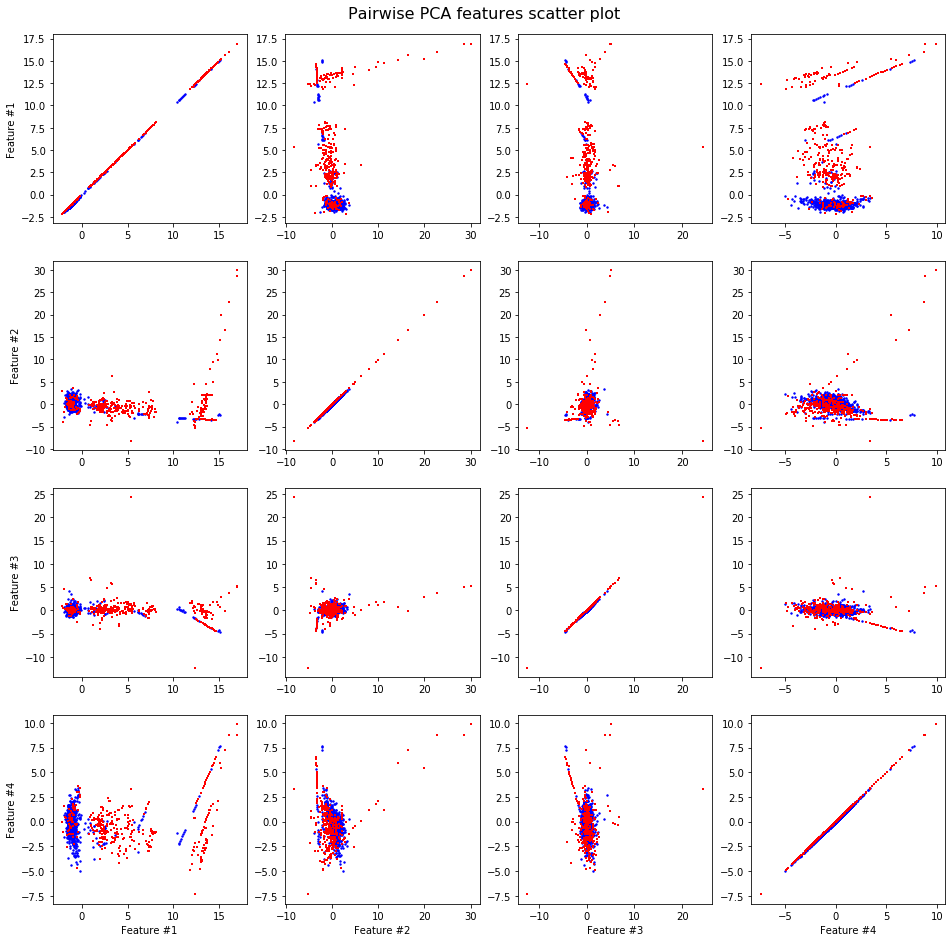

In [9]:
# Apply PCA to get top features & visualize using pair-wise plots

def pairwise_pca_plot(row, col, axs):

    global x_pca_dim, num_components, y_label
    
    x = x_pca_dim[:, col]
    y = x_pca_dim[:, row]
    
    x_pos = x[(y_label == 1)]
    y_pos = y[(y_label == 1)]
    x_neg = x[(y_label == 0)]
    y_neg = y[(y_label == 0)]

    axs.scatter(x_neg, y_neg, label = 'Not Fraud', s = 2, c = 'b')
    axs.scatter(x_pos, y_pos, label = 'Fraud', s = 4, c = 'r', marker = '+')

    if row == num_components-1:
        x_lab = 'Feature #' + str(col+1)
        axs.set(xlabel = x_lab)
    if col == 0:
        y_lab = 'Feature #' + str(row+1)
        axs.set(ylabel = y_lab)

    
# Standardizing the data - necessary for PCA
x = feature_data.iloc[:,:-1].to_numpy()
y_label = feature_data.iloc[:,-1].to_numpy()

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Apply PCA - select the number of components
num_components = 4    #Imp: Don't increase this value beyond 5
pca = decomposition.PCA(n_components=num_components)
x_pca_dim = pca.fit_transform(x_scaled)

# Setting up the pairwise plot
fig_size = min(num_components*4, 16)
fig = plt.figure(figsize = (fig_size,fig_size))
fig.subplots_adjust(wspace = 0.2)
fig.suptitle('Pairwise PCA features scatter plot', fontsize = 16, y = 0.9 + 0.001*num_features)
axs = fig.subplots(num_components,num_components)

for i in range(num_components**2):
    row = i//num_components
    col = i%num_components
    pairwise_pca_plot(row, col, axs[row, col])
